# Tutorial: Dynamic Lines

This tutorial will introduce an example of considering dynamic lines in `LITS`.
Note that this tutorial is for `LITS 0.4.0`. 

This tutorial presents a simulation of a three-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1, a one d- one q- machine on bus 2 and an inverter of 19 states, as a virtual synchronous machine at bus 3. The perturbation will be the trip of two of the three circuits (triplicating its resistance and impedance) of the line that connects bus 1 and bus 3. This case also consider a dynamic line model for connection between buses 2 and 3. We will compare it against a system without dynamic lines.

It is recommended to check `Tutorial 1: OMIB` first, since that includes more details and explanations on all definitions and functions.

## Step 1: Package Initialization

In [4]:
using LITS
using PowerSystems
using Sundials
using Plots
const PSY = PowerSystems

PowerSystems

## Step 2: Load the System and Data creation: Static Case

In [5]:
sys_file_dir = joinpath("Data/ThreeBusInverter.raw")
threebus_sys = System(PowerModelsData(sys_file_dir), runchecks = false);

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/common.jl:26
┌ Info: Constructing System from Power Models
│   data["name"] = threebusinverter
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:418
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:575
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:638
┌ Info: Reading DC Line 

In [6]:
#Attach an infinite source at bus 1.
function add_source_to_ref(sys::PSY.System)
    for g in PSY.get_components(StaticInjection, sys)
        isa(g, ElectricLoad) && continue
        g.bus.bustype == BusTypes.REF &&
            error("A device is already attached to the REF bus")
    end

    #Find the Slack bus
    slack_bus = [b for b in PSY.get_components(Bus, sys) if b.bustype == BusTypes.REF][1]
    inf_source = Source(
        name = "InfBus", #name
        available = true, #availability
        active_power = 0.0,
        reactive_power = 0.0,
        bus = slack_bus, #bus
        R_th = 0.0,
        X_th = 5e-6, #Xth
    )
    PSY.add_component!(sys, inf_source)
    return
end

add_source_to_ref(threebus_sys)

Dynamic Generator Data:

In [7]:
#Create the machine
machine_oneDoneQ() = OneDOneQMachine(
    0.0, #R
    1.3125, #Xd
    1.2578, #Xq
    0.1813, #Xd_p
    0.25, #Xq_p
    5.89, #Td0_p
    0.6, #Tq0_p
)

#Shaft
shaft_no_damping() = SingleMass(
    3.01, #H (M = 6.02 -> H = M/2)
    0.0,
) #D

#AVR: Type I: Resembles a DC1 AVR
avr_type1() = AVRTypeI(
    20.0, #Ka - Gain
    0.01, #Ke
    0.063, #Kf
    0.2, #Ta
    0.314, #Te
    0.35, #Tf
    0.001, #Tr
    5.0, #Vrmax
    -5.0, #Vrmin
    0.0039, #Ae - 1st ceiling coefficient
    1.555, #Be - 2nd ceiling coefficient
) 

#No TG
tg_none() = TGFixed(1.0) #efficiency

#No PSS
pss_none() = PSSFixed(0.0) #Vs

#Construct the generator
function dyn_gen_second_order(generator)
    return PSY.DynamicGenerator(
        generator,
        1.0, # ω_ref,
        machine_oneDoneQ(), #machine
        shaft_no_damping(), #shaft
        avr_type1(), #avr
        tg_none(), #tg
        pss_none(), #pss
    )
end

dyn_gen_second_order (generic function with 1 method)

Dynamic Inverter Data:

In [8]:
#Define converter as an AverageConverter
converter_high_power() = AverageConverter(rated_voltage = 138.0, rated_current = 100.0)

#Define Outer Control as a composition of Virtual Inertia + Reactive Power Droop
function outer_control()
    function virtual_inertia()
        return VirtualInertia(Ta = 2.0, kd = 400.0, kω = 20.0)
    end
    function reactive_droop()
        return ReactivePowerDroop(kq = 0.2, ωf = 1000.0)
    end
    return OuterControl(virtual_inertia(), reactive_droop())
end

#Define an Inner Control as a Voltage+Current Controler with Virtual Impedance:
inner_control() = CurrentControl(
    kpv = 0.59,     #Voltage controller proportional gain
    kiv = 736.0,    #Voltage controller integral gain
    kffv = 0.0,     #Binary variable enabling the voltage feed-forward in output of current controllers
    rv = 0.0,       #Virtual resistance in pu
    lv = 0.2,       #Virtual inductance in pu
    kpc = 1.27,     #Current controller proportional gain
    kic = 14.3,     #Current controller integral gain
    kffi = 0.0,     #Binary variable enabling the current feed-forward in output of current controllers
    ωad = 50.0,     #Active damping low pass filter cut-off frequency
    kad = 0.2,      #Active damping gain
)

#Define DC Source as a FixedSource:
dc_source_lv() = FixedDCSource(voltage = 600.0)

#Define a Frequency Estimator as a PLL based on Vikram Kaura and Vladimir Blaskoc 1997 paper:
pll() = KauraPLL(
    ω_lp = 500.0, #Cut-off frequency for LowPass filter of PLL filter.
    kp_pll = 0.084,  #PLL proportional gain
    ki_pll = 4.69,   #PLL integral gain
)

#Define an LCL filter:
filt() = LCLFilter(lf = 0.08, rf = 0.003, cf = 0.074, lg = 0.2, rg = 0.01)

#Construct the Inverter:
function inv_case78(static_device)
    return PSY.DynamicInverter(
        static_device,
        1.0, # ω_ref,
        converter_high_power(), #converter
        outer_control(), #outer control
        inner_control(), #inner control voltage source
        dc_source_lv(), #dc source
        pll(), #pll
        filt(), #filter
    )
end

inv_case78 (generic function with 1 method)

Attach dynamic devices to the system:

In [9]:
for g in get_components(Generator, threebus_sys)
    if get_number(get_bus(g)) == 102
        case_gen = dyn_gen_second_order(g)
        add_component!(threebus_sys, case_gen)
    elseif get_number(get_bus(g)) == 103
        case_inv = inv_case78(g)
        add_component!(threebus_sys, case_inv)
    end
end

## Step 3: Build the simulation and initializing the problem

We first create the fault

In [10]:
#Make a copy of the original system
sys2 = System(PowerModelsData(sys_file_dir), runchecks = false)
add_source_to_ref(sys2)
#Triplicates the impedance of the line named "1"
fault_branches = get_components(ACBranch, sys2)
for br in fault_branches
    if get_name(br) == "1"
        br.r = 3 * br.r
        br.x = 3 * br.x
        b_new = (from = br.b.from / 3, to = br.b.to / 3)
        br.b = b_new
    end
end
#Obtain the new Ybus
Ybus_fault = Ybus(sys2).data
#Define Fault: Change of YBus
Ybus_change = LITS.ThreePhaseFault(
    1.0, #change at t = 1.0
    Ybus_fault, #New YBus
);

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/common.jl:26
┌ Info: Constructing System from Power Models
│   data["name"] = threebusinverter
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:418
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:575
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:638
┌ Info: Reading DC Line 

and now we create the simulation

In [11]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = Simulation(
    pwd(), #folder to output results
    threebus_sys, #system
    tspan, #time span
    Ybus_change, #Type of perturbation
)

┌ Info: Serialized time series data to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_BgCBiU/sys_time_series_storage.h5.
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/time_series_storage.jl:53
┌ Info: Serialized System to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_BgCBiU/sys.json
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/serialization.jl:8
┌ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_nz3tlh
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/hdf5_time_series_storage.jl:82
┌ Info: Unit System changed to DEVICE_BASE
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/base.jl:352
┌ Info: The System has no islands
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/utils/network_calculations/ybus_calculations

Simulation()


In [12]:
print_device_states(sim)

Voltage Variables
BUS 1       
Vm 1.02
θ -0.0
BUS 2       
Vm 1.0142
θ -0.0247
BUS 3       
Vm 1.0059
θ 0.05
Differential States
generator-102-1
eq_p 0.6478
ed_p 0.6672
δ 0.9386
ω 1.0
Vf 1.0781
Vr1 0.0333
Vr2 -0.1941
Vm 1.0142
Differential States
generator-103-1
ω_oc 1.0
θ_oc 0.4573
q_oc -0.4453
ξd_ic 0.0013
ξq_ic 0.0004
γd_ic 0.0615
γq_ic -0.0138
ϕd_ic 0.8765
ϕq_ic -0.1978
vd_pll 0.8986
vq_pll 0.0
ε_pll -0.0
θ_pll 0.2354
ir_cnv 0.7462
ii_cnv 0.757
vr_filter 0.8738
vi_filter 0.2095
ir_filter 0.7617
ii_filter 0.6923


## Step 4: Run the Simulation

In [13]:
run_simulation!(sim, IDA(), dtmax = 0.02)

## Step 5: Store the solution

In [14]:
series2 = get_voltagemag_series(sim, 102)
zoom = [
        (series2[1][ix], series2[2][ix])
        for (ix, s) in enumerate(series2[1]) if (s > 0.90 && s < 1.6)
    ];

## Step 2.1: Create the Dynamic Line system

In [26]:
sys_file_dir = joinpath("Data/ThreeBusInverter.raw")
threebus_sys_dyn = System(PowerModelsData(sys_file_dir), runchecks = false)
add_source_to_ref(threebus_sys_dyn)

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/common.jl:26
┌ Info: Constructing System from Power Models
│   data["name"] = threebusinverter
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:418
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:575
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:638
┌ Info: Reading DC Line 

An important aspect to consider is that DynamicLines must not be considered in the computation of the Ybus.
First we construct the Dynamic Line, by finding the Line named "3", and then adding it to the system.

In [27]:
dyn_branch = DynamicBranch(get_component(Branch, threebus_sys_dyn, "3"))
add_component!(threebus_sys_dyn, dyn_branch)

Add the dynamic devices to the DynamicLines system

In [28]:
# Add the Dynamic Components
for g in get_components(Generator, threebus_sys_dyn)
    if get_number(get_bus(g)) == 102
        case_gen = dyn_gen_second_order(g)
        add_component!(threebus_sys_dyn, case_gen)
    elseif get_number(get_bus(g)) == 103
        case_inv = inv_case78(g)
        add_component!(threebus_sys_dyn, case_inv)
    end
end

Similarly, we construct the Ybus fault by creating a copy of the original system, but removing the Line "3" to avoid considering it in the Ybus:

In [29]:
sys3 = System(PowerModelsData(sys_file_dir), runchecks = false)
add_source_to_ref(sys3)
remove_component!(Line, sys3, "3")

#Create Ybus_Fault
fault_branches2 = get_components(Line, sys3)
for br in fault_branches2
    if get_name(br) == "1"
        br.r = 3 * br.r
        br.x = 3 * br.x
        b_new = (from = br.b.from / 3, to = br.b.to / 3)
        br.b = b_new
    end
end
Ybus_fault2 = Ybus(sys3).data;

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/common.jl:26
┌ Info: Constructing System from Power Models
│   data["name"] = threebusinverter
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:418
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:575
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:638
┌ Info: Reading DC Line 

In [30]:
#time span
tspan = (0.0, 30.0)

#Define Fault: Change of YBus
Ybus_change2 = LITS.ThreePhaseFault(
    1.0, #change at t = 1.0
    Ybus_fault2,
) #New YBus

ThreePhaseFault(1.0, 
  [1, 1]  =  0.91954-10.9011im
  [2, 1]  =  -0.689655+8.27586im
  [3, 1]  =  -0.229885+2.75862im
  [1, 2]  =  -0.689655+8.27586im
  [2, 2]  =  0.689655-8.17586im
  [1, 3]  =  -0.229885+2.75862im
  [3, 3]  =  0.229885-2.72529im)

In [31]:
sim2 = Simulation(
        pwd(),
        threebus_sys_dyn, #system
        tspan, #time span
        Ybus_change2, #Type of Fault
    )

┌ Info: Serialized time series data to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_93VSFC/sys_time_series_storage.h5.
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/time_series_storage.jl:53
┌ Info: Serialized System to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_93VSFC/sys.json
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/serialization.jl:8
┌ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_kANG9x
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/hdf5_time_series_storage.jl:82
┌ Info: Unit System changed to DEVICE_BASE
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/base.jl:352
┌ Info: The System has no islands
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/utils/network_calculations/ybus_calculations

Simulation()


In [32]:
print_device_states(sim2)

Voltage Variables
BUS 1       
Vm 1.02
θ -0.0
BUS 2       
Vm 1.0142
θ -0.0247
BUS 3       
Vm 1.0059
θ 0.05
Differential States
generator-102-1
eq_p 0.6478
ed_p 0.6672
δ 0.9386
ω 1.0
Vf 1.0781
Vr1 0.0333
Vr2 -0.1941
Vm 1.0142
Differential States
generator-103-1
ω_oc 1.0
θ_oc 0.4573
q_oc -0.4453
ξd_ic 0.0013
ξq_ic 0.0004
γd_ic 0.0615
γq_ic -0.0138
ϕd_ic 0.8765
ϕq_ic -0.1978
vd_pll 0.8986
vq_pll 0.0
ε_pll -0.0
θ_pll 0.2354
ir_cnv 0.7462
ii_cnv 0.757
vr_filter 0.8738
vi_filter 0.2095
ir_filter 0.7617
ii_filter 0.6923
Line Current States
Line 3
Il_R -0.08348
Il_I -0.01213


## Step 4.1: Run the simulation of the Dynamic Lines System

In [33]:
run_simulation!(sim2, IDA(), dtmax=0.02)

## Step 5.1: Store the solution

In [34]:
series2_dyn = get_voltagemag_series(sim2, 102)
zoom_dyn = [
        (series2_dyn[1][ix], series2_dyn[2][ix])
        for (ix, s) in enumerate(series2_dyn[1]) if (s > 0.90 && s < 1.6)
    ];

## Step 6.1: Compare the solutions:

We can observe the effect of Dynamic Lines

In [35]:
plot(series2_dyn, label="V_gen_dyn")
plot!(series2, label="V_gen_st", xlabel="Time [s]", ylabel = "Voltage [pu]")

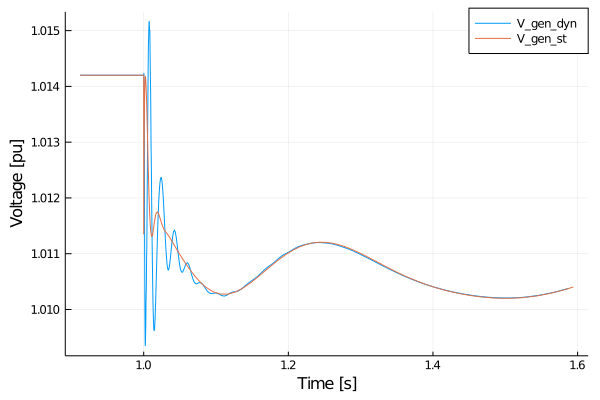

In [36]:
plot(zoom_dyn, label="V_gen_dyn")
plot!(zoom, label="V_gen_st", xlabel="Time [s]", ylabel = "Voltage [pu]")